## シミュレータ
- 勝敗により、どうやってレートが更新されるか
- Nチームを段階的に強さを変えている
    - i番目のチームはi-1番目のチームよりr倍強い
- 勝率は強さの比
- 総当りをN回繰り返して、レート変化を見る

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
rate = 1.2
N = 10
loop = 100

class Country():
    def __init__(self, strength,fifa_rate,rugby_rate,name=""):
        self.name = name
        self.strength = strength
        self.fifa_rate = rugby_rate
        self.rugby_rate = fifa_rate
        
    def update_FIFA(self, is_win, opponent_rate):
        # FIFAランキング用レート
        diff_rate = opponent_rate - self.fifa_rate 
        ex = 1/(10**(diff_rate/600)+1)
        if is_win:
            # 勝った場合
            score = 30 * (1 - ex)
            self.fifa_rate += score
            # self.fifa_rate += max(score, 60)
        else:
            # 負けた場合
            score = 30 * ex
            self.fifa_rate -= score
            # self.fifa_rate -= max(score, 50)

    def update_rugby(self,is_win,opponent_rate):
        # ラグビー用レート
        diff_rate = opponent_rate - self.rugby_rate
        if is_win:#勝ち
            # 自分のほうが高い場合
            if diff_rate < 0:
                self.rugby_rate += max(0, 1+0.1*diff_rate)
            else:
                self.rugby_rate += min(2, 1+0.1*diff_rate)        
        else: #負け
            if diff_rate < 0:
                self.rugby_rate -= min(2, 1-0.1*diff_rate)
            else:
                self.rugby_rate -= max(0, 1-0.1*diff_rate)

            
cs = []
for i in range(N):
    c = Country(rate**i, 60, 1200)
    cs.append(c)
cs[-1].strength = cs[-2].strength

# 総当りトーナメント loop回繰り返す
for _ in range(loop):
    for i in range(N):
        for j in range(i+1,N):
            n = random.random()
            c_i = cs[i]
            c_j = cs[j]
            win_i = (c_i.strength/(c_i.strength+c_j.strength))
            if win_i >= n:
                # iの勝ち
                c_i.update_FIFA(is_win=True, opponent_rate=c_j.fifa_rate)
                c_j.update_FIFA(is_win=False, opponent_rate=c_i.fifa_rate)
                c_i.update_rugby(is_win=True, opponent_rate=c_j.rugby_rate)
                c_j.update_rugby(is_win=False, opponent_rate=c_i.rugby_rate)                
                winner = i
            else:
                # jの勝ち
                c_i.update_FIFA(is_win=False, opponent_rate=c_j.fifa_rate)
                c_j.update_FIFA(is_win=True, opponent_rate=c_i.fifa_rate)
                c_i.update_rugby(is_win=False, opponent_rate=c_j.rugby_rate)
                c_j.update_rugby(is_win=True, opponent_rate=c_i.rugby_rate)

                winner = j
            # print("{}:{} -> {} rate {},{}".format(i,j,winner,cs[i].rugby_rate,cs[j].rugby_rate))

## 結果の表示

In [2]:
for i,c in enumerate(cs):
    print("{}, {:.2f},  {:.2f}.  {:.2f}".format(i,c.strength, c.fifa_rate, c.rugby_rate))

0, 1.00,  974.81.  56.40
1, 1.20,  1008.06.  55.01
2, 1.44,  1008.24.  54.77
3, 1.73,  1182.34.  60.59
4, 2.07,  1216.91.  59.07
5, 2.49,  1112.40.  55.27
6, 2.99,  1267.22.  60.96
7, 3.58,  1405.70.  64.91
8, 4.30,  1439.55.  64.86
9, 4.30,  1357.22.  61.98


## ELO Rating

- $R_A$ : 自分 
- $R_B$ : 相手
- $p$ : パラメータ(実力差とレート差の対応)
- 勝った場合 $\mathrm{rate} = 1-\frac{1}{1+10^{(R_A-R_B)/p}}$ 足す
- 負けた場合 $-\frac{1}{1+10^{(R_A-R_B)/p}}$ 引く

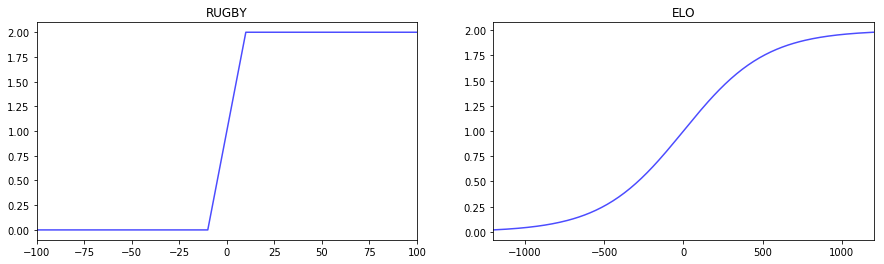

In [3]:
def curve(diff,p):
    return 2*(1-1/(10**(diff/p)+1))
def rugby(diff):
    ans = []
    for d in diff:
        if d > 0:
            ans.append(min(2,1+0.1*d))
        else:
            ans.append(max(0,1+0.1*d))
    return np.array(ans)

# 2個のグラフの比較
plt.figure(figsize=(15,4))
plt.subplot(121)
x1 = np.linspace(-100,100,201)
plt.xlim(-100,100)
# ラグビーのレート傾斜
plt.plot(x1,rugby(x1),"b",alpha=0.7)
plt.title("RUGBY")
x1 = np.linspace(-1200,1200,201)
plt.subplot(122)
# FIFAランキングのレーティング曲線はp=600に設定されている
plt.plot(x1,curve(x1,600),"b",alpha=0.7)
plt.title("ELO")
plt.xlim(-1200,1200)
plt.savefig("rate_comparison.png")

## 近似

$\mathrm{rate} = 2\times\left(1-\frac{1}{1+10^{(R_A-R_B)/p}}\right) $

カクカクから曲線に近似しようか。

- -15から15くらいの当てはまりを見る
- 差の総和で判断(abs)



/home/imaimai/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


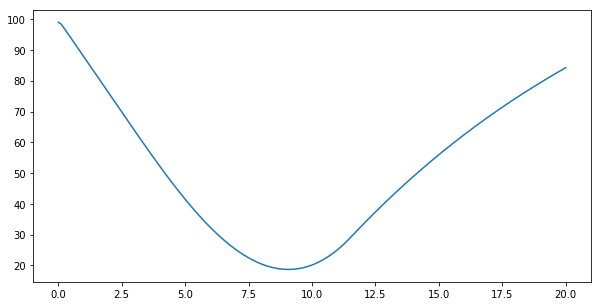

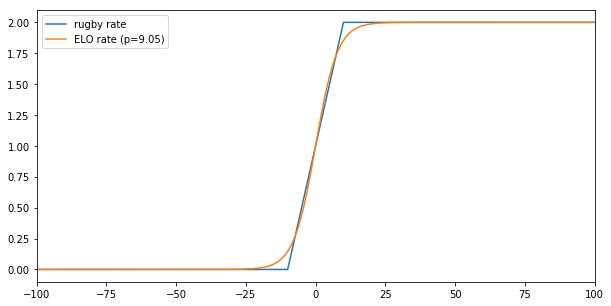

In [4]:
ps = np.linspace(0.01,20,200)
diffs = []
for p in ps:
    x = np.linspace(-15,15,301)
    f1 = rugby(x) # ラグビー
    f2 = curve(x,p)# ELO Rating
    diff = abs(f1-f2)
    diffs.append(diff.sum())

plt.figure(figsize=(10,5))
plt.plot(ps,diffs)

# 最小値を求める
diffs = np.array(diffs)
ind = np.argmin(diffs)
p_min = ps[ind]

# 近似曲線とプロット
plt.figure(figsize=(10,5))
x1 = np.linspace(-100,100,201)
plt.plot(x1,rugby(x1),label="rugby rate")
plt.plot(x1,curve(x1,p_min),label="ELO rate (p={:.2f})".format(p_min))
plt.xlim(-100,100)
plt.legend()
plt.savefig("approx.png")

レート差と強さの反映
(2019/12/04時点)

In [5]:
r_sa = 94.19
r_ireland = 84.45
r_japan = 79.28

# 日本とアイルランド
p_a = 1/(1+10**((r_ireland-r_japan)/p_min))
print(p_a)
p_a = 1/(1+10**((r_sa-r_japan)/p_min))
print(p_a)


0.2116017820946373
0.022026293847367925
